## Disentangling the effect of hybrid interactions and of the constant effort hypothesis on ecological community stability

In [1]:
import math
import numpy as np
import itertools
import seaborn as sns
np.random.seed(12345) 
import matplotlib.pyplot as plt
import matplotlib.patches as pat
%matplotlib inline

### Generate random matrix

In [2]:
def generate_matrix_indep(S, C, pM=0.5, seed=None, sigma=1.0):
    # Random matrix, model independent
    if seed is not None:
        np.random.seed(seed)

    A = np.zeros((S, S), float)

    for i,j in itertools.product(range(S),range(S)):
        if (i>j): continue
        if (i==j): A[i,j]= -1# -np.random.random() # self interaction
        elif (np.random.random()) < C: # Connection
            if (np.random.random()) < pM: # Mutualistic link
                A[i][j] = np.abs(np.random.normal(0,sigma))
                A[j][i] = np.abs(np.random.normal(0,sigma))
            else:
                #if (np.random.random()) < 0.5: # Predator-prey link
                A[i][j] = np.abs(np.random.normal(0,sigma))
                A[j][i] = -1*np.abs(np.random.normal(0,sigma)) 
    return A            


In [3]:
def generate_matrix(S, C, pM=0.5, fM=1, fA=1, structure='cascade', CIE=True, seed=None):
    """
    Returns LV interaction matrix a, (SxS).
    link_type coding:
      +1 : mutualism stored once at (u,v) with u < v
      -1 : predation stored once at (pred, prey) with pred != prey
       0 : no link
    """

    rng = np.random.default_rng(seed)

    # Preference matrix 
    A = np.zeros((S, S), float)
    # LV interaction matrix
    a = np.zeros((S, S), float)
    # link types for bookkeeping 
    link_type = np.zeros((S, S), int)

    # Aliases
    if structure == 'mutualistic':
        pM = 1.0
        structure = 'random'
    elif structure == 'predator-prey':
        pM = 0.0
        structure = 'random'

    # Build network structure
    if structure == 'random':
        # For each unordered pair (u<v), decide if connected.
        for u in range(S):
            for v in range(u + 1, S):
                if rng.random() >= C:
                    continue

                if rng.random() < pM:
                    # mutualism stored once at (u,v)
                    link_type[u, v] = 1
                    link_type[v, u] = 1
                    A[u, v] = rng.random()
                    A[v, u] = rng.random()
                else:
                    # antagonism: choose a direction randomly
                    if rng.random() < 0.5:
                        pred, prey = u, v
                    else:
                        pred, prey = v, u
                    link_type[pred, prey] = -1
                    w = rng.random()
                    A[pred, prey] = w
                    A[prey, pred] = w

        for i in range(S):
            A[i, i] = -rng.random()
  
    elif structure == 'cascade':
        # cascade ordering: only consider pairs (i>j)
        for i in range(S):
            for j in range(i):  # j < i, each unordered pair once
                if rng.random() >= C:
                    continue

                if rng.random() < pM:
                    # Mutualism between i and j
                    u, v = j, i  # j<i
                    link_type[u, v] = 1
                    link_type[v, u] = 1
                    # A holds nonnegative weights in both directions
                    A[u, v] = rng.random()
                    A[v, u] = rng.random()
                else:
                    # Predation: by cascade convention i eats j 
                    pred, prey = i, j
                    link_type[pred, prey] = -1
                    # Store A weights
                    w = rng.random()
                    A[pred, prey] = w
                    A[prey, pred] = w 

        # Make sure each predator has a prey:
        #for pred in range(1, S):
        #    if not np.any(link_type[pred, :pred] == -1):  # no prey
        #        prey = rng.integers(0, pred)
        #        link_type[pred, prey] = -1
        #        w = rng.random()
        #        A[pred, prey] = w
        #        A[prey, pred] = w
                
        # self-regulation 
        for i in range(S):
            A[i, i] = -rng.random()

    elif structure == 'bipartite':
        # bipartite mutualism only between two groups
        half = S // 2
        # connection probability scaling: 2*C*(S-1)/S
        p_conn = 2 * C * (S - 1) / S

        for i in range(half):
            for j in range(half, S):
                if rng.random() >= p_conn:
                    continue
                u, v = (i, j) if i < j else (j, i)
                link_type[u, v] = 1
                link_type[v, u] = 1
                A[u, v] = rng.random()
                A[v, u] = rng.random()

        for i in range(S):
            A[i, i] = -rng.random()

    else:
        raise ValueError(f"Unknown structure='{structure}'")

    # Build resource sets + CIE denominators

    # Mutualistic adjacency reconstructed from stored upper triangle
    M_adj = np.zeros((S, S), dtype=bool)
    mutual_pairs = np.argwhere(link_type == 1)  # these are (u,v) with u<v
    for u, v in mutual_pairs:
        M_adj[u, v] = True
        M_adj[v, u] = True

    # Predation adjacency (directed predator->prey)
    P_adj = (link_type == -1)

    # resources(i) = mutual partners(i) ∪ prey(i)
    resources = []
    denom = np.zeros(S, dtype=float)
    for i in range(S):
        mutual_i = np.where(M_adj[i, :])[0]
        prey_i = np.where(P_adj[i, :])[0]      # outgoing predation links
        res_i = np.unique(np.concatenate([mutual_i, prey_i]))
        resources.append(res_i)
        denom[i] = A[i, res_i].sum() if res_i.size > 0 else 0.0
        #denom[i] += A[i,i] # self regulation
        #if denom[i] == 0:
        #    print(f'Denominator is 0 for species {i}')
        #    denom[i] = 1


    # If CIE is off, denominators are 1
    if not CIE:
        denom[:] = 1.0

    # Avoid division by zero; better is to ensure each species has resources, but guard anyway
    eps = 0# 1e-12
    denom_safe = np.maximum(denom, eps)

    # Create a for LV
    # Self-regulation 
    for i in range(S):
        a[i, i] = A[i, i] 

    # Mutualism: use denominators of each species separately
    for u, v in mutual_pairs:
        # u < v by construction
        e_uv = rng.random()
        e_vu = rng.random()

        a[u, v] = fM * e_uv * A[u, v] / denom_safe[u]
        a[v, u] = fM * e_vu * A[v, u] / denom_safe[v]

    # Predation: for each predator->prey, normalize directions by predator denom
    preds, preys = np.where(P_adj)
    for pred, prey in zip(preds, preys):
        gij = rng.random()

        a[pred, prey] = fA * gij * A[pred, prey] / denom_safe[pred]
        #a[prey, pred] = -fA * A[prey, pred] / denom_safe[pred]
        a[prey, pred] = -fA * A[pred, prey] / denom_safe[pred] # same as (4)??

    return a, A, link_type, denom


def construct_r_for_equilibrium(a, n_star):
    """
    To make n_star a fixed point: r = -a @ n_star
    """
    return -(a @ n_star)

def jacobian_at_equilibrium(a, n_star):
    """
    Jacobian at equilibrium for dn_i/dt = n_i ( r_i + sum_j a_ij n_j )
    At equilibrium:
      J_ij = n_i^* a_ij
    """
    return (n_star[:, None] * a)


In [4]:
def generate_cascade_matrix(S, C, pM=0.5, fM=1, fA=1, structure='cascade', CIE=True, seed=None):
    """
    Returns LV interaction matrix a, (SxS).
    link_type coding:
      +1 : mutualism stored once at (u,v) with u < v
      -1 : predation stored once at (pred, prey) with pred != prey
       0 : no link
    """

    rng = np.random.default_rng(seed)

    # Preference matrix 
    A = np.zeros((S, S), float)
    # LV interaction matrix
    a = np.zeros((S, S), float)
    # link types for bookkeeping 
    link_type = np.zeros((S, S), int)

    # Build network structure  
    # cascade ordering: only consider pairs (i>j)
    for i in range(S):
        for j in range(i):  # j < i, each unordered pair once
            if rng.random() >= C:
                continue

            if rng.random() < pM:
                # Mutualism between i and j
                u, v = j, i  # j<i
                link_type[u, v] = 1
                # A holds nonnegative weights in both directions
                A[u, v] = rng.random()
                A[v, u] = rng.random()
            else:
                # Predation: by cascade convention i eats j 
                pred, prey = i, j
                link_type[pred, prey] = -1
                # Store A weights
                w = rng.random()
                A[pred, prey] = w
                A[prey, pred] = w 

        # Make sure each predator has a prey:
        #for pred in range(1, S):
        #    if not np.any(link_type[pred, :pred] == -1):  # no prey
        #        prey = rng.integers(0, pred)
        #        link_type[pred, prey] = -1
        #        w = rng.random()
        #        A[pred, prey] = w
        #        A[prey, pred] = w
                
        # self-regulation 
        for i in range(S):
            A[i, i] = -rng.random()


    # Build resource sets + CIE denominators

    # Mutualistic adjacency reconstructed from stored upper triangle
    M_adj = np.zeros((S, S), dtype=bool)
    mutual_pairs = np.argwhere(link_type == 1)  # these are (u,v) with u<v
    for u, v in mutual_pairs:
        M_adj[u, v] = True
        M_adj[v, u] = True

    # Predation adjacency (directed predator->prey)
    P_adj = (link_type == -1)

    # resources(i) = mutual partners(i) ∪ prey(i)
    resources = []
    denom = np.zeros(S, dtype=float)
    for i in range(S):
        mutual_i = np.where(M_adj[i, :])[0]
        prey_i = np.where(P_adj[i, :])[0]      # outgoing predation links
        res_i = np.unique(np.concatenate([mutual_i, prey_i]))
        resources.append(res_i)
        denom[i] = A[i, res_i].sum() if res_i.size > 0 else 0.0
        #denom[i] += A[i,i] # self regulation
        #if denom[i] == 0:
        #    print(f'Denominator is 0 for species {i}')
        #    denom[i] = 1


    # If CIE is off, denominators are 1
    if not CIE:
        denom[:] = 1.0

    # Avoid division by zero; better is to ensure each species has resources, but guard anyway
    eps = 0# 1e-12
    denom_const = S * C * (pM + 0.5*(1-pM)) * 0.5

    # Create a for LV
    # Self-regulation 
    for i in range(S):
        a[i, i] = A[i, i] 

    # Mutualism: use denominators of each species separately
    for u, v in mutual_pairs:
        # u < v by construction
        e_uv = rng.random()
        e_vu = rng.random()

        a[u, v] = fM * e_uv * A[u, v] / denom_const
        a[v, u] = fM * e_vu * A[v, u] / denom_const

    # Predation: for each predator->prey, normalize directions by predator denom
    preds, preys = np.where(P_adj)
    for pred, prey in zip(preds, preys):
        gij = rng.random()

        a[pred, prey] = fA * gij * A[pred, prey] / denom_const
        #a[prey, pred] = -fA * A[prey, pred] / denom_safe[pred]
        a[prey, pred] = -fA * A[pred, prey] / denom_const # same as (4)??

    return a, A, link_type, denom


In [5]:
def plot_matrix(a, title="Interaction matrix a"):
    plt.figure(figsize=(6, 6))

    vmax = np.max(np.abs(a))
    im = plt.imshow(a, cmap="RdBu_r", vmin=-vmax, vmax=vmax)

    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xlabel("j")
    plt.ylabel("i")
    plt.tight_layout()
    plt.show()

def plot_sign_structure(a, title="Sign structure"):
    sign_mat = np.sign(a)

    plt.figure(figsize=(6, 6))
    im = plt.imshow(sign_mat, cmap="RdBu_r", vmin=-1, vmax=1)

    plt.colorbar(im, ticks=[-1, 0, 1])
    plt.title(title)
    plt.xlabel("j")
    plt.ylabel("i")
    plt.tight_layout()
    plt.show()    

def diagnostic_stats(a):
    print("Mean diagonal:", np.mean(np.diag(a)))
    print("Max |a_ij|:", np.max(np.abs(a)))
    print("Mean positive row sum:", np.mean(np.sum(np.clip(a,0,np.inf),axis=1)))
    print("Mean negative row sum:", np.mean(-np.sum(np.clip(a,-np.inf,0),axis=1)))

def debug_outliers(a, topk=10):
    abs_a = np.abs(a.copy())
    np.fill_diagonal(abs_a, 0.0)
    flat_idx = np.argsort(abs_a.ravel())[::-1]
    rows, cols = np.unravel_index(flat_idx[:topk], a.shape)

    print("Top |a_ij| entries (off-diagonal):")
    for r, c in zip(rows, cols):
        print(f"  (i={r:3d}, j={c:3d})  a_ij={a[r,c]: .3e}")

    print("\nGlobal stats:")
    print("  max |a_ij| (offdiag):", abs_a.max())
    print("  median |a_ij| (offdiag):", np.median(abs_a[abs_a > 0]))
    print("  count(|a_ij|>1e3):", np.sum(abs_a > 1e3))

### Eigenvalues distribution

Text(0.5, 0.98, 'C: 0.2    S: 50')

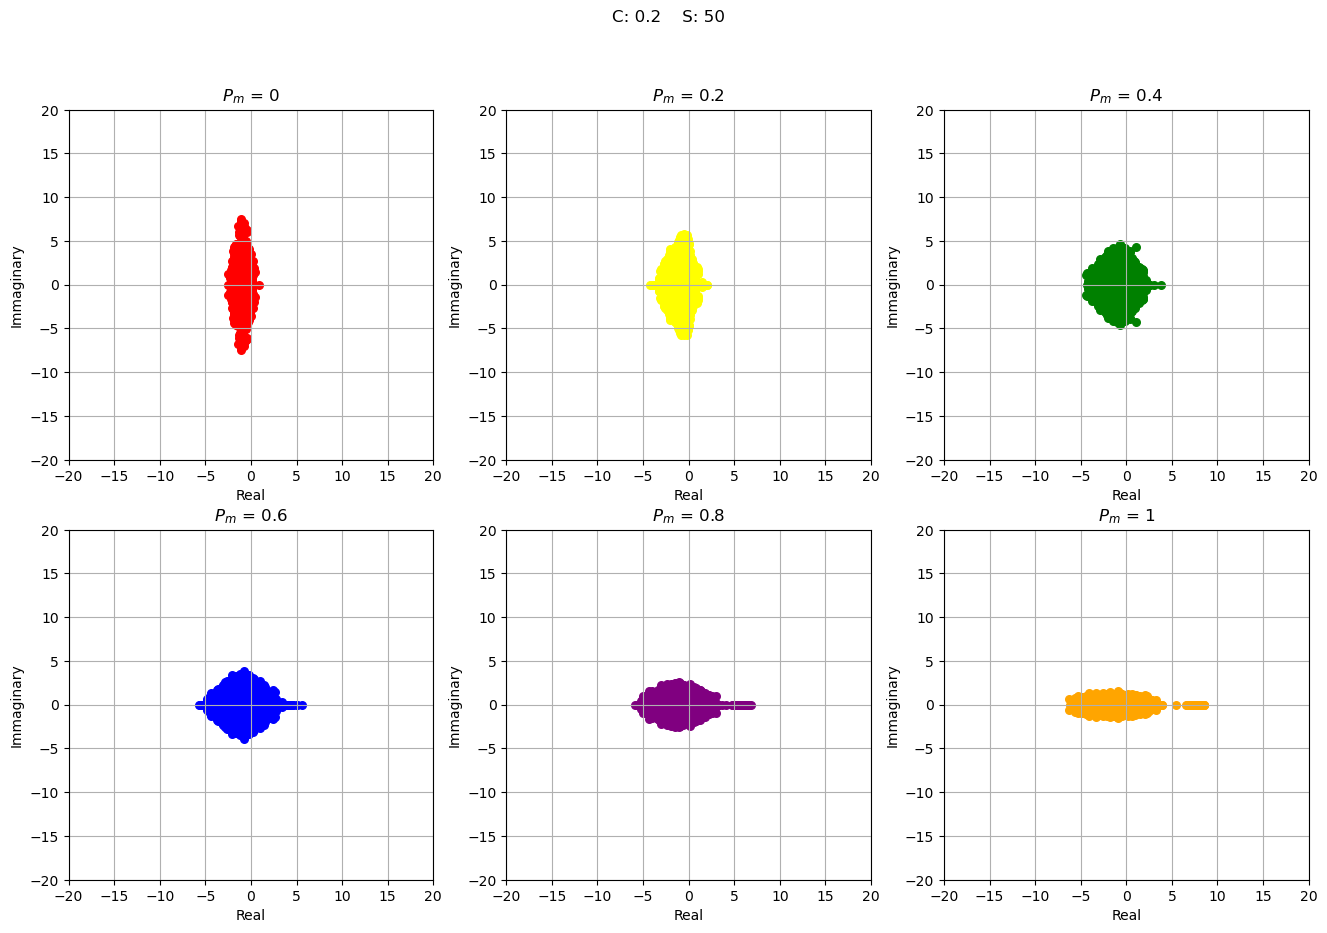

In [6]:
S =50 # species
d = 0 # self interaction
c = .2
sigma = 1

iterations = 50

Pm_list = [0,.2,.4,.6,.8,1]
color = ['red', 'yellow', 'green', 'blue', 'purple', 'orange']
count = 0

fig, ax = plt.subplots(2,3, figsize=(16,10))
for Pm in Pm_list:
    re=[]
    im=[]
    for t in range(iterations):
        d = np.random.sample() # self interaction
        M = np.zeros((S,S))

        M = generate_matrix_indep(S, c, sigma=sigma, pM=Pm)
        eig, _ = np.linalg.eig(M)
        re.append(eig.real)
        im.append(eig.imag)

    if count <= 2:
        ax[0][count].scatter(re, im, alpha=1, s=30, c=color[count])
        ax[0][count].set_title(f'$P_m$ = {Pm}')
        ax[0][count].set_xlabel('Real')
        ax[0][count].set_ylabel('Immaginary')
        ax[0][count].set_xlim(-20,20)
        ax[0][count].set_ylim(-20,20)
        ax[0][count].grid()
    else:
        ax[1][count%3].scatter(re, im, alpha=1, s=30, c=color[count])
        ax[1][count%3].set_title(f'$P_m$ = {Pm}')
        ax[1][count%3].set_xlabel('Real')
        ax[1][count%3].set_ylabel('Immaginary') 
        ax[1][count%3].set_xlim(-20,20)
        ax[1][count%3].set_ylim(-20,20)   
        ax[1][count%3].grid()
    count += 1

fig.suptitle(f'C: {c}    S: {S}')

Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0


Text(0.5, 0.98, 'C: 0.2    S: 200')

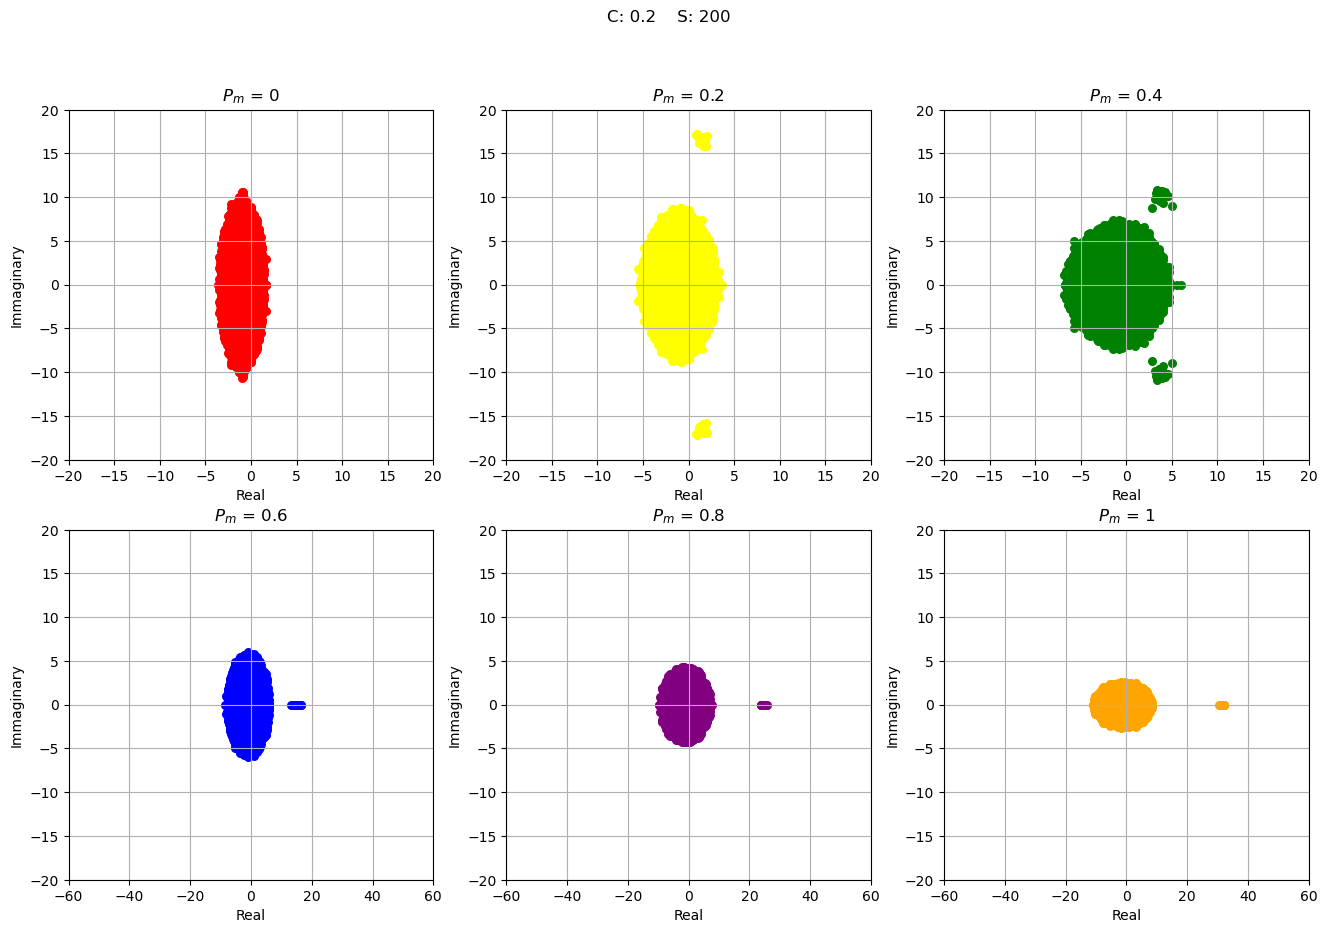

In [7]:
S =200 # species
d = 0 # self interaction

iterations = 20
M = np.zeros((S,S))

c = .2
sigma = 1
Pm_list = [0,.2,.4,.6,.8,1]
color = ['red', 'yellow', 'green', 'blue', 'purple', 'orange']
count = 0

fig, ax = plt.subplots(2,3, figsize=(16,10))
for Pm in Pm_list:
    re=[]
    im=[]
    for t in range(iterations):
        if t % 50 == 0: print(f'Iteration: {t}')
        M = np.zeros((S,S))

        M = generate_matrix_indep(S, c, sigma=sigma, pM=Pm)
        eig, _ = np.linalg.eig(M)
        re.append(eig.real)
        im.append(eig.imag)
    
    if count <= 2:
        ax[0][count].scatter(re, im, alpha=1, s=30, c=color[count])
        ax[0][count].set_title(f'$P_m$ = {Pm}')
        ax[0][count].set_xlabel('Real')
        ax[0][count].set_ylabel('Immaginary')
        ax[0][count].set_xlim(-20,20)
        ax[0][count].set_ylim(-20,20)
        ax[0][count].grid()
    else:
        ax[1][count%3].scatter(re, im, alpha=1, s=30, c=color[count])
        ax[1][count%3].set_title(f'$P_m$ = {Pm}')
        ax[1][count%3].set_xlabel('Real')
        ax[1][count%3].set_ylabel('Immaginary') 
        ax[1][count%3].set_xlim(-60,60)
        ax[1][count%3].set_ylim(-20,20)   
        ax[1][count%3].grid()
    count += 1

fig.suptitle(f'C: {c}    S: {S}')

Text(0.5, 0.98, 'C: 0.8    S: 50')

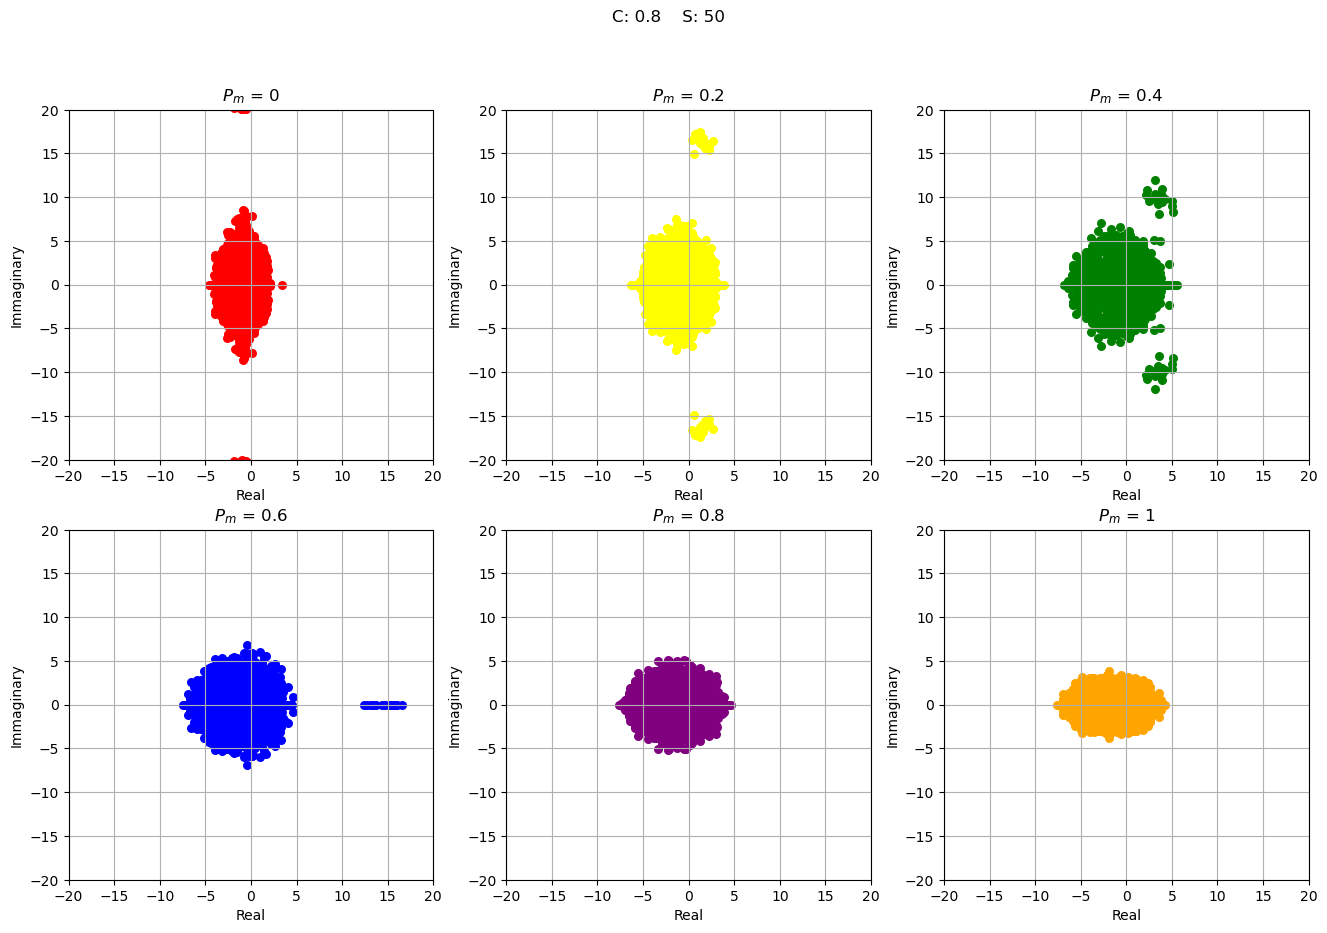

In [8]:
S =50 # species
d = 0 # self interaction

iterations = 20
M = np.zeros((S,S))

c = .8
sigma = 1
Pm_list = [0,.2,.4,.6,.8,1]
color = ['red', 'yellow', 'green', 'blue', 'purple', 'orange']
count = 0

fig, ax = plt.subplots(2,3, figsize=(16,10))
for Pm in Pm_list:
    re=[]
    im=[]
    for t in range(iterations):
        M = np.zeros((S,S))

        M = generate_matrix_indep(S, c, sigma=sigma, pM=Pm)
        eig, _ = np.linalg.eig(M)
        re.append(eig.real)
        im.append(eig.imag)
    
    if count <= 2:
        ax[0][count].scatter(re, im, alpha=1, s=30, c=color[count])
        ax[0][count].set_title(f'$P_m$ = {Pm}')
        ax[0][count].set_xlabel('Real')
        ax[0][count].set_ylabel('Immaginary')
        ax[0][count].set_xlim(-20,20)
        ax[0][count].set_ylim(-20,20)
        ax[0][count].grid()
    else:
        ax[1][count%3].scatter(re, im, alpha=1, s=30, c=color[count])
        ax[1][count%3].set_title(f'$P_m$ = {Pm}')
        ax[1][count%3].set_xlabel('Real')
        ax[1][count%3].set_ylabel('Immaginary') 
        ax[1][count%3].set_xlim(-20,20)
        ax[1][count%3].set_ylim(-20,20)   
        ax[1][count%3].grid()
    count += 1

fig.suptitle(f'C: {c}    S: {S}')

## Matrix structures

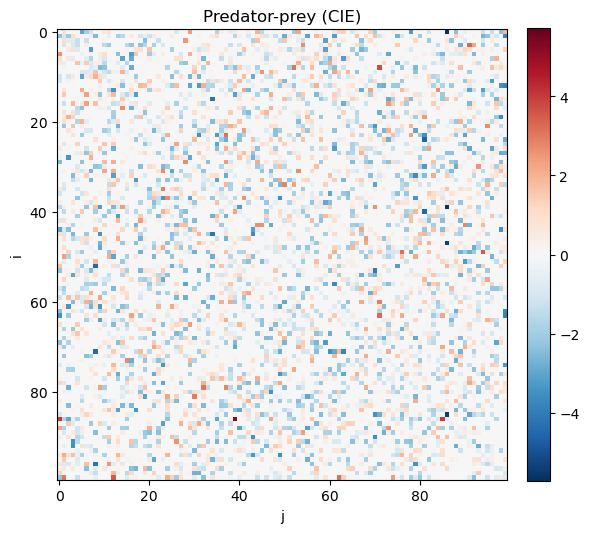

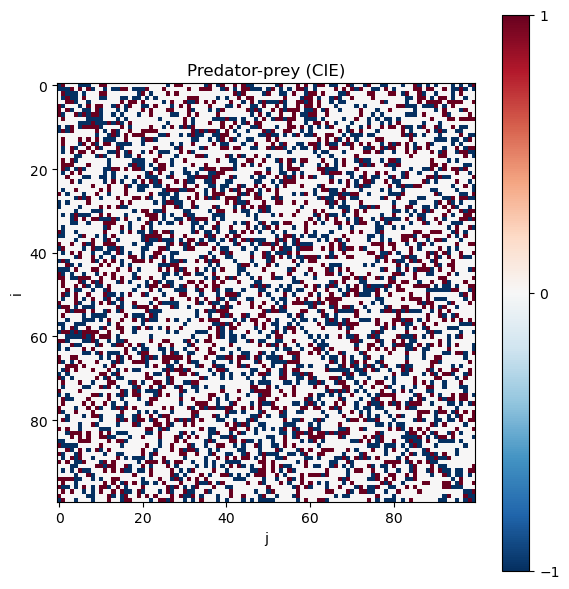

Top |a_ij| entries (off-diagonal):
  (i=  0, j= 86)  a_ij=-5.731e+00
  (i= 39, j= 86)  a_ij=-5.575e+00
  (i= 85, j= 86)  a_ij=-5.383e+00
  (i= 47, j= 86)  a_ij=-5.367e+00
  (i= 86, j= 39)  a_ij= 5.176e+00
  (i= 24, j= 81)  a_ij=-4.540e+00
  (i= 52, j=  8)  a_ij=-4.513e+00
  (i= 40, j= 81)  a_ij=-4.489e+00
  (i= 71, j=  8)  a_ij=-4.392e+00
  (i= 96, j=  8)  a_ij=-4.230e+00
  (i= 15, j= 34)  a_ij=-4.189e+00
  (i= 45, j= 34)  a_ij=-4.140e+00
  (i= 53, j= 70)  a_ij=-4.044e+00
  (i= 86, j= 85)  a_ij= 4.022e+00
  (i= 86, j=  0)  a_ij= 4.016e+00

Global stats:
  max |a_ij| (offdiag): 5.731159070140136
  median |a_ij| (offdiag): 0.9354206527953595
  count(|a_ij|>1e3): 0
Mean diagonal: -0.47246704708119935
Max |a_ij|: 5.731159070140136
Mean positive row sum: 15.430866639357632
Mean negative row sum: 30.4724670470812
denom stats:
  min denom: 4.733409616682696
  # denom==0: 0
  10 smallest denom: [4.73340962 6.0914899  6.3280911  6.45799619 6.94840917 7.04710308
 7.52296677 7.76860058 7.78684025

In [19]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0, fA=30, structure='predator-prey', CIE=True)
plot_matrix(a, title="Predator-prey (CIE)")
plot_sign_structure(a, title="Predator-prey (CIE)")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

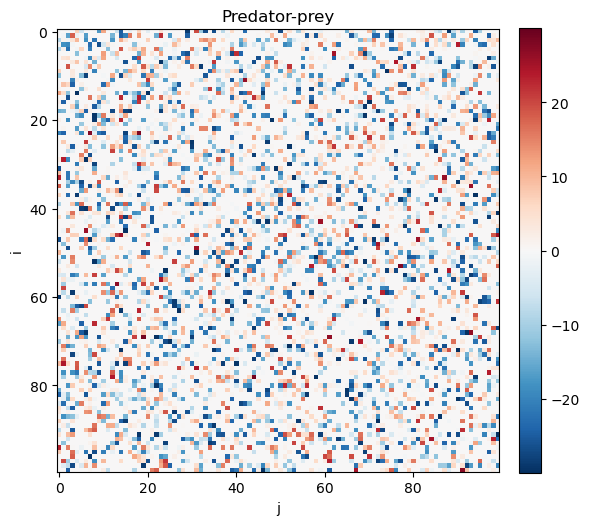

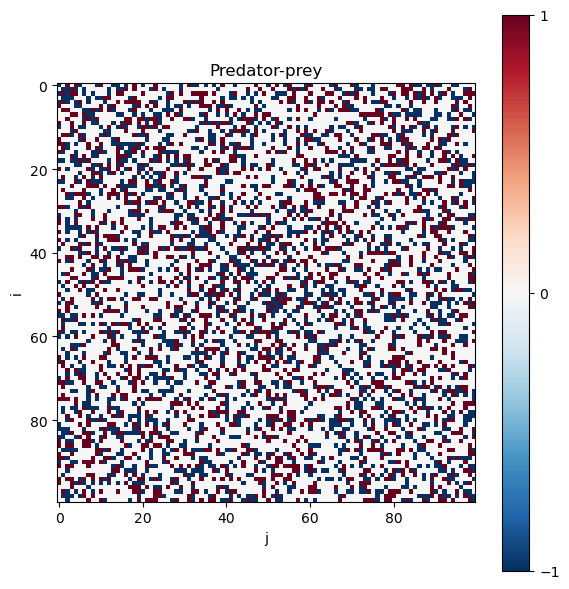

Top |a_ij| entries (off-diagonal):
  (i= 27, j= 85)  a_ij=-3.000e+01
  (i= 71, j= 52)  a_ij=-2.999e+01
  (i= 72, j= 90)  a_ij=-2.998e+01
  (i= 16, j= 70)  a_ij=-2.997e+01
  (i= 14, j= 20)  a_ij=-2.991e+01
  (i= 51, j= 58)  a_ij=-2.987e+01
  (i= 63, j= 27)  a_ij=-2.987e+01
  (i= 55, j= 38)  a_ij=-2.986e+01
  (i= 91, j= 99)  a_ij=-2.981e+01
  (i= 37, j= 94)  a_ij=-2.976e+01
  (i= 88, j= 72)  a_ij=-2.976e+01
  (i=  7, j= 23)  a_ij=-2.974e+01
  (i= 41, j= 99)  a_ij=-2.972e+01
  (i= 70, j= 25)  a_ij=-2.971e+01
  (i= 45, j= 15)  a_ij=-2.970e+01

Global stats:
  max |a_ij| (offdiag): 29.99931292836676
  median |a_ij| (offdiag): 9.41440194216964
  count(|a_ij|>1e3): 0
Mean diagonal: -0.5345412926116773
Max |a_ij|: 29.99931292836676
Mean positive row sum: 142.3101458038718
Mean negative row sum: 289.14205791695326
denom stats:
  min denom: 1.0
  # denom==0: 0
  10 smallest denom: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
max entry at: (np.int64(27), np.int64(85)) a_ij= -29.99931292836676
denom[i]= 1.0 de

In [37]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0, fA=30, structure='predator-prey', CIE=False)
plot_matrix(a, title="Predator-prey")
plot_sign_structure(a, title="Predator-prey")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

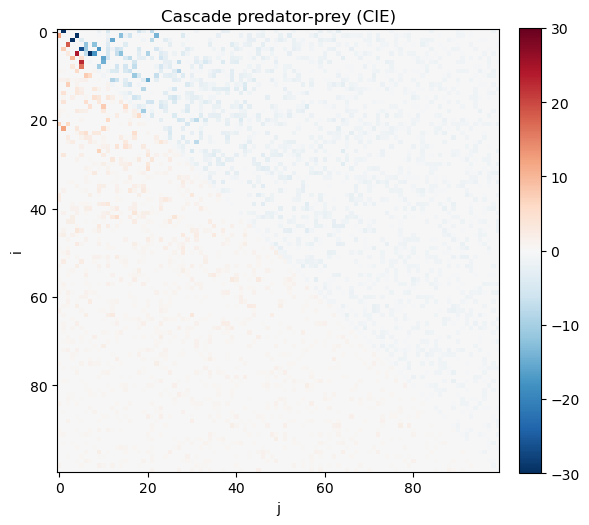

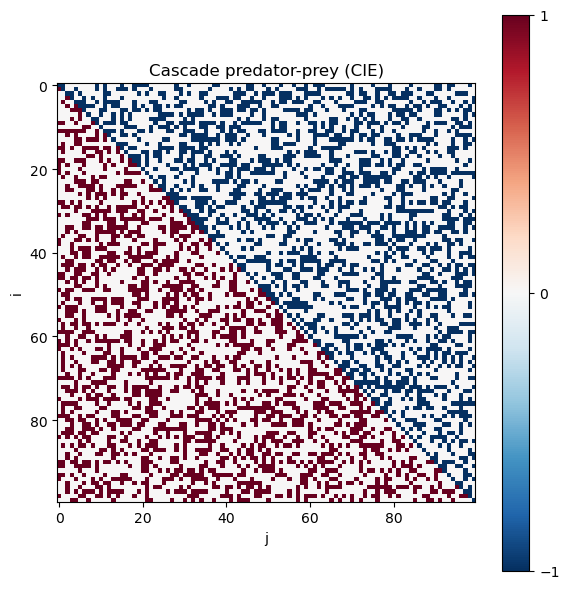

Top |a_ij| entries (off-diagonal):
  (i=  5, j=  7)  a_ij=-3.000e+01
  (i=  0, j=  1)  a_ij=-3.000e+01
  (i=  1, j=  4)  a_ij=-3.000e+01
  (i=  2, j=  3)  a_ij=-3.000e+01
  (i=  4, j=  5)  a_ij=-2.644e+01
  (i=  5, j=  4)  a_ij= 2.425e+01
  (i=  7, j=  5)  a_ij= 2.260e+01
  (i=  3, j=  2)  a_ij= 1.842e+01
  (i=  5, j=  8)  a_ij=-1.775e+01
  (i=  4, j=  9)  a_ij=-1.745e+01
  (i=  8, j=  5)  a_ij= 1.611e+01
  (i=  6, j= 10)  a_ij=-1.565e+01
  (i=  2, j= 12)  a_ij=-1.515e+01
  (i= 11, j= 20)  a_ij=-1.459e+01
  (i=  7, j= 10)  a_ij=-1.435e+01

Global stats:
  max |a_ij| (offdiag): 30.000000000000004
  median |a_ij| (offdiag): 0.744150022240704
  count(|a_ij|>1e3): 0
Mean diagonal: -0.5227373578244499
Max |a_ij|: 30.000000000000004
Mean positive row sum: 14.547465061386262
Mean negative row sum: 29.92273735782445
denom stats:
  min denom: 0.0
  # denom==0: 2
  10 smallest denom: [0.         0.         0.07116709 0.31327566 0.44709355 0.82172113
 1.04016707 1.13594055 1.25921501 1.49833748]


In [21]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0., fA=30, structure='cascade', CIE=True)
plot_matrix(a, title="Cascade predator-prey (CIE)")
plot_sign_structure(a, title="Cascade predator-prey (CIE)")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

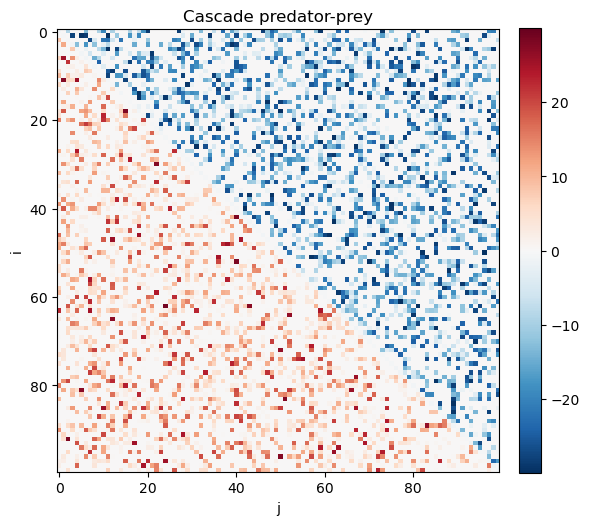

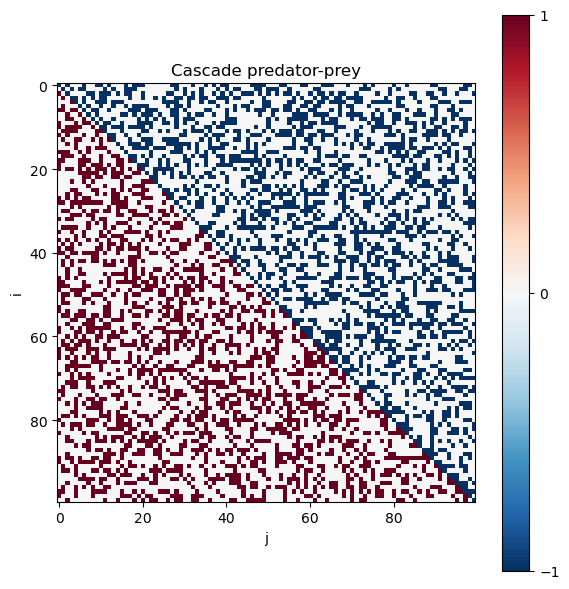

Top |a_ij| entries (off-diagonal):
  (i= 11, j= 79)  a_ij=-2.998e+01
  (i=  1, j= 11)  a_ij=-2.996e+01
  (i= 40, j= 42)  a_ij=-2.994e+01
  (i= 46, j= 61)  a_ij=-2.990e+01
  (i= 15, j= 85)  a_ij=-2.985e+01
  (i= 61, j= 77)  a_ij=-2.983e+01
  (i= 13, j= 63)  a_ij=-2.979e+01
  (i= 18, j= 50)  a_ij=-2.975e+01
  (i= 62, j= 81)  a_ij=-2.975e+01
  (i= 15, j= 18)  a_ij=-2.974e+01
  (i= 43, j= 62)  a_ij=-2.972e+01
  (i= 22, j= 30)  a_ij=-2.971e+01
  (i= 26, j= 31)  a_ij=-2.971e+01
  (i= 84, j= 89)  a_ij=-2.967e+01
  (i= 24, j= 62)  a_ij=-2.967e+01

Global stats:
  max |a_ij| (offdiag): 29.98085698680424
  median |a_ij| (offdiag): 9.67025824033815
  count(|a_ij|>1e3): 0
Mean diagonal: -0.5198803081380113
Max |a_ij|: 29.98085698680424
Mean positive row sum: 144.53783626924843
Mean negative row sum: 291.69622476906227
denom stats:
  min denom: 1.0
  # denom==0: 0
  10 smallest denom: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
max entry at: (np.int64(11), np.int64(79)) a_ij= -29.98085698680424
denom[i]= 1.0 d

In [22]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0, fA=30, structure='cascade', CIE=False)
plot_matrix(a, title="Cascade predator-prey")
plot_sign_structure(a, title="Cascade predator-prey")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

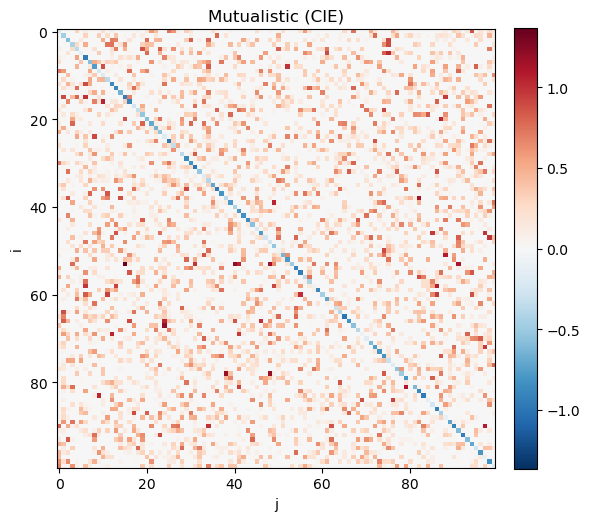

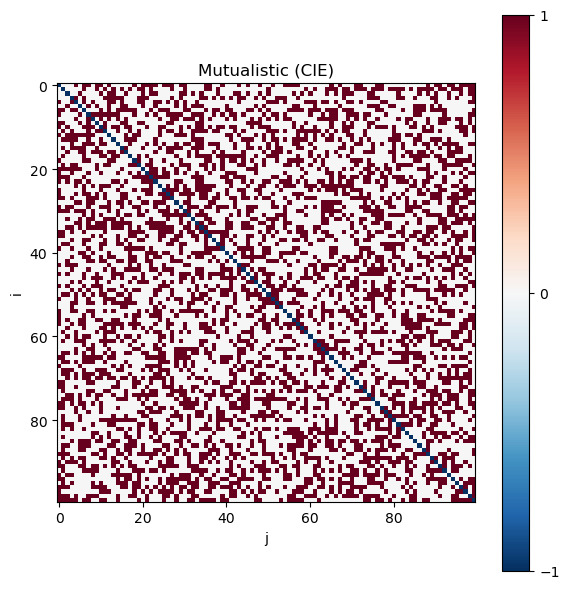

Top |a_ij| entries (off-diagonal):
  (i= 53, j= 15)  a_ij= 1.367e+00
  (i= 53, j= 40)  a_ij= 1.210e+00
  (i= 67, j= 24)  a_ij= 1.205e+00
  (i= 78, j= 48)  a_ij= 1.185e+00
  (i= 78, j= 38)  a_ij= 1.180e+00
  (i= 53, j= 48)  a_ij= 1.150e+00
  (i= 38, j= 82)  a_ij= 1.125e+00
  (i= 53, j= 91)  a_ij= 1.112e+00
  (i= 81, j= 79)  a_ij= 1.089e+00
  (i= 58, j= 86)  a_ij= 1.075e+00
  (i= 51, j= 88)  a_ij= 1.072e+00
  (i= 90, j= 97)  a_ij= 1.068e+00
  (i= 53, j= 41)  a_ij= 1.052e+00
  (i= 69, j= 12)  a_ij= 1.042e+00
  (i= 16, j= 10)  a_ij= 1.038e+00

Global stats:
  max |a_ij| (offdiag): 1.36658648415975
  median |a_ij| (offdiag): 0.19542580023931003
  count(|a_ij|>1e3): 0
Mean diagonal: -0.5467562819022125
Max |a_ij|: 1.36658648415975
Mean positive row sum: 10.26729511881474
Mean negative row sum: 0.5467562819022125
denom stats:
  min denom: 11.905633119510124
  # denom==0: 0
  10 smallest denom: [11.90563312 12.89919244 14.81522154 14.85170531 14.89931607 15.24028051
 15.30099216 15.35994947 15

In [23]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0, fM = 20, fA=30, structure='mutualistic', CIE=True)
plot_matrix(a, title="Mutualistic (CIE)")
plot_sign_structure(a, title="Mutualistic (CIE)")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

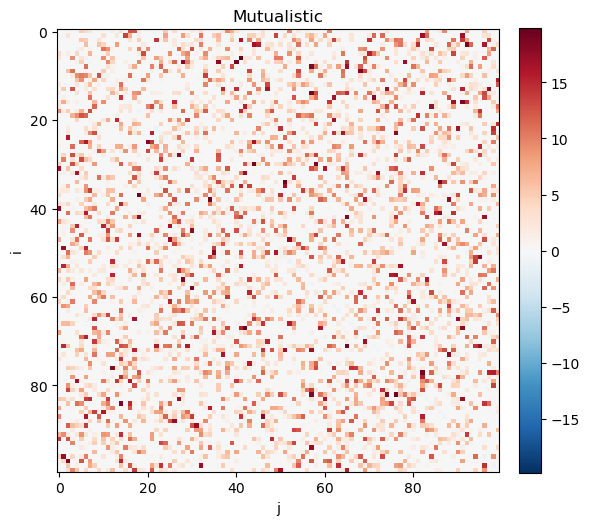

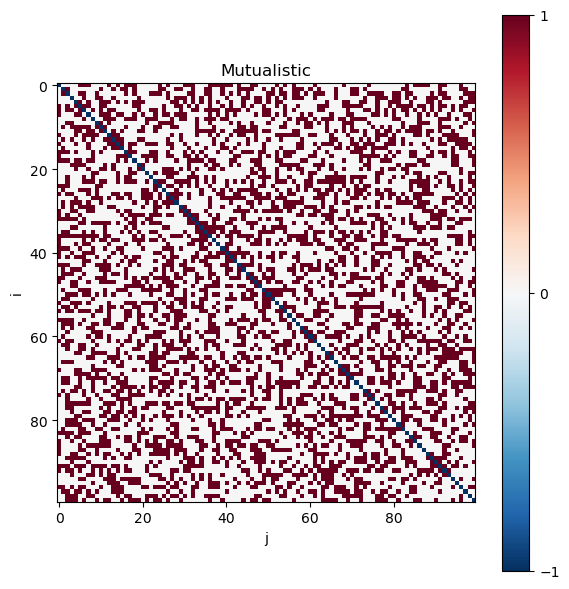

Top |a_ij| entries (off-diagonal):
  (i=  6, j= 41)  a_ij= 1.985e+01
  (i= 67, j= 42)  a_ij= 1.979e+01
  (i= 37, j= 18)  a_ij= 1.964e+01
  (i= 34, j= 51)  a_ij= 1.940e+01
  (i= 38, j= 34)  a_ij= 1.919e+01
  (i= 82, j= 76)  a_ij= 1.918e+01
  (i=  7, j= 40)  a_ij= 1.914e+01
  (i= 77, j= 82)  a_ij= 1.904e+01
  (i= 30, j= 44)  a_ij= 1.898e+01
  (i= 14, j= 57)  a_ij= 1.897e+01
  (i= 84, j= 14)  a_ij= 1.884e+01
  (i= 71, j= 65)  a_ij= 1.884e+01
  (i=  3, j= 92)  a_ij= 1.882e+01
  (i= 30, j= 58)  a_ij= 1.879e+01
  (i= 58, j= 30)  a_ij= 1.871e+01

Global stats:
  max |a_ij| (offdiag): 19.847045301919415
  median |a_ij| (offdiag): 3.711116630321402
  count(|a_ij|>1e3): 0
Mean diagonal: -0.4781708841589246
Max |a_ij|: 19.847045301919415
Mean positive row sum: 197.32500723751772
Mean negative row sum: 0.4781708841589246
denom stats:
  min denom: 1.0
  # denom==0: 0
  10 smallest denom: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
max entry at: (np.int64(6), np.int64(41)) a_ij= 19.847045301919415
denom[i]= 1.0

In [36]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0, fM=20, fA=30, structure='mutualistic', CIE=False)
plot_matrix(a, title="Mutualistic")
plot_sign_structure(a, title="Mutualistic")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

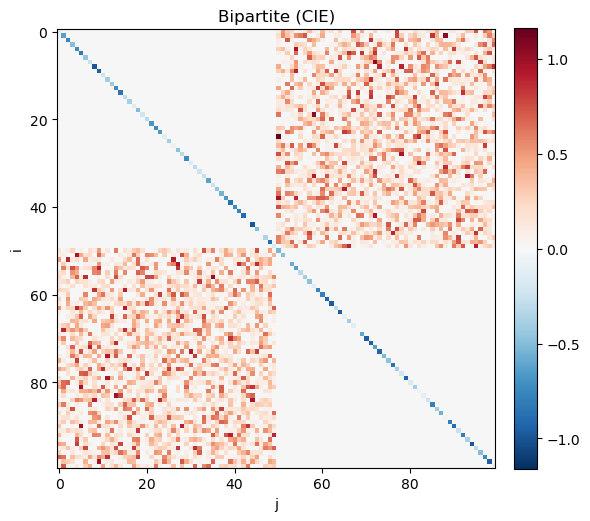

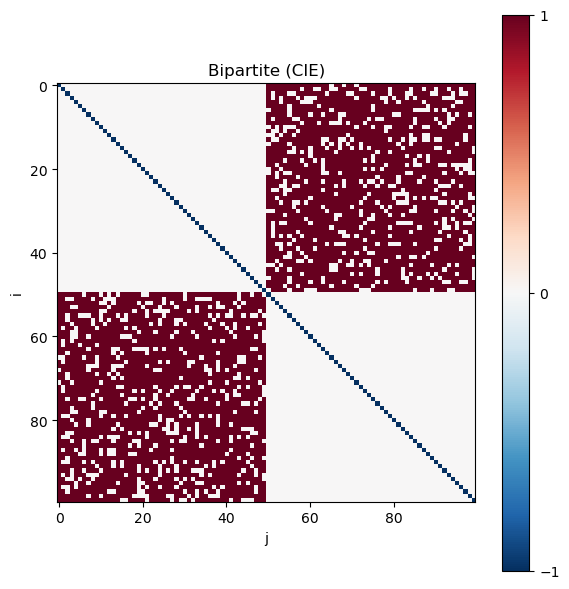

Top |a_ij| entries (off-diagonal):
  (i= 24, j= 50)  a_ij= 1.162e+00
  (i= 19, j= 58)  a_ij= 1.053e+00
  (i=  1, j= 88)  a_ij= 1.044e+00
  (i=  7, j= 72)  a_ij= 1.035e+00
  (i= 56, j= 35)  a_ij= 1.023e+00
  (i= 83, j= 13)  a_ij= 9.799e-01
  (i= 90, j=  5)  a_ij= 9.750e-01
  (i= 38, j= 50)  a_ij= 9.686e-01
  (i= 81, j=  5)  a_ij= 9.627e-01
  (i= 98, j=  9)  a_ij= 9.546e-01
  (i= 51, j=  4)  a_ij= 9.531e-01
  (i=  4, j= 54)  a_ij= 9.486e-01
  (i= 79, j= 11)  a_ij= 9.469e-01
  (i= 53, j= 27)  a_ij= 9.455e-01
  (i= 28, j= 78)  a_ij= 9.445e-01

Global stats:
  max |a_ij| (offdiag): 1.1618601510152995
  median |a_ij| (offdiag): 0.18693549148755068
  count(|a_ij|>1e3): 0
Mean diagonal: -0.5044795576911204
Max |a_ij|: 1.1618601510152995
Mean positive row sum: 9.956303342742011
Mean negative row sum: 0.5044795576911204
denom stats:
  min denom: 13.730522937555866
  # denom==0: 0
  10 smallest denom: [13.73052294 14.54503137 14.93339733 14.94968736 15.8532956  15.9162351
 15.94317073 16.61303517

In [38]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0.5, fM=20, fA=30, structure='bipartite', CIE=True)
plot_matrix(a, title="Bipartite (CIE)")
plot_sign_structure(a, title="Bipartite (CIE)")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

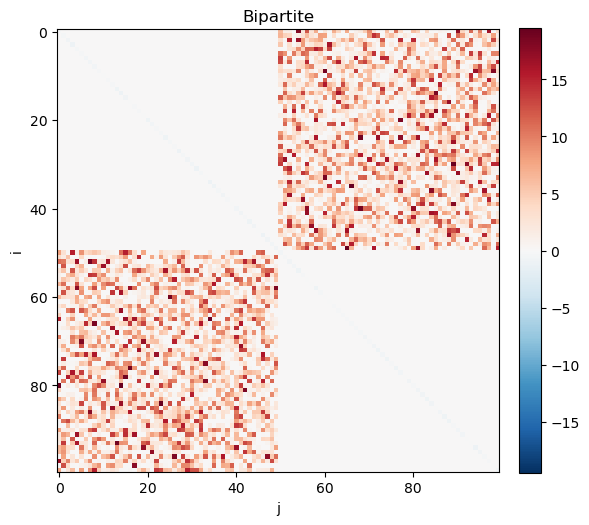

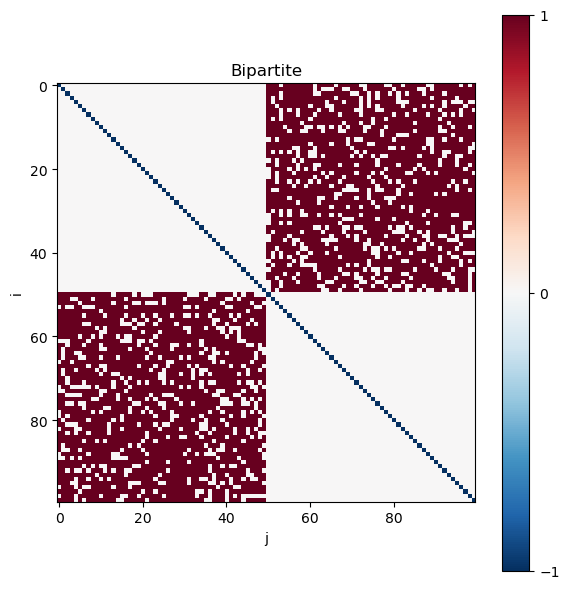

Top |a_ij| entries (off-diagonal):
  (i= 35, j= 66)  a_ij= 1.949e+01
  (i= 49, j= 65)  a_ij= 1.929e+01
  (i= 80, j= 14)  a_ij= 1.929e+01
  (i= 30, j= 89)  a_ij= 1.928e+01
  (i= 84, j= 23)  a_ij= 1.923e+01
  (i= 80, j=  0)  a_ij= 1.921e+01
  (i= 65, j= 34)  a_ij= 1.898e+01
  (i= 78, j= 15)  a_ij= 1.894e+01
  (i= 60, j= 25)  a_ij= 1.885e+01
  (i= 76, j= 16)  a_ij= 1.884e+01
  (i= 24, j= 68)  a_ij= 1.882e+01
  (i= 93, j= 13)  a_ij= 1.878e+01
  (i= 40, j= 68)  a_ij= 1.869e+01
  (i= 52, j=  7)  a_ij= 1.868e+01
  (i=  9, j= 60)  a_ij= 1.867e+01

Global stats:
  max |a_ij| (offdiag): 19.488886121901164
  median |a_ij| (offdiag): 3.8008854135929475
  count(|a_ij|>1e3): 0
Mean diagonal: -0.47117120976236637
Max |a_ij|: 19.488886121901164
Mean positive row sum: 200.82775387910354
Mean negative row sum: 0.47117120976236637
denom stats:
  min denom: 1.0
  # denom==0: 0
  10 smallest denom: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
max entry at: (np.int64(35), np.int64(66)) a_ij= 19.488886121901164
denom[i]=

In [39]:
a, A, link_type, denom = generate_matrix(S=100, C=0.4, pM=0, fM=20, fA=30, structure='bipartite', CIE=False)
plot_matrix(a, title="Bipartite")
plot_sign_structure(a, title="Bipartite")
debug_outliers(a, topk=15)
diagnostic_stats(a)

print("denom stats:")
print("  min denom:", denom.min())
print("  # denom==0:", np.sum(denom == 0))
print("  10 smallest denom:", np.sort(denom)[:10])

abs_a = np.abs(a.copy())
np.fill_diagonal(abs_a, 0.0)
i, j = np.unravel_index(np.argmax(abs_a), a.shape)
print("max entry at:", (i, j), "a_ij=", a[i,j])
print("denom[i]=", denom[i], "denom[j]=", denom[j])

## Study stability as a function of pM

C=0.2, pM=0.0 

  Realization 0
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
C=0.2, pM=0.1111111111111111 

  Realization 0
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
C=0.2, pM=0.2222222222222222 

  Realization 0
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
C=0.2, pM=0.3333333333333333 

  Realization 0
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
C=0.2, pM=0.4444444444444444 

  Realization 0
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realizati

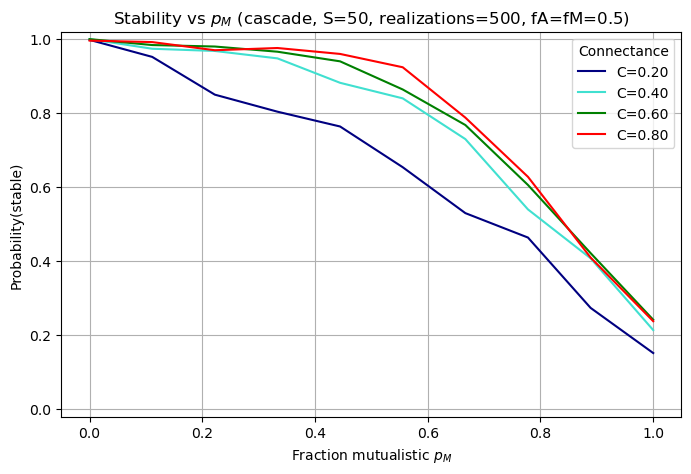

In [27]:
# Stability vs pM for cascade matrices
S = 50
C_list = [0.2, 0.4, 0.6, 0.8]
pM_grid = np.linspace(0.0, 1.0, 10)
fA = 0.5
fM = 0.5
structure = 'cascade'
n_realizations = 500

results = {}
for C in C_list:
    probs = np.zeros(len(pM_grid))
    for idx, pM in enumerate(pM_grid):
        print(f"C={C}, pM={pM} \n")
        stable_count = 0
        for rep in range(n_realizations):
            if rep % 50 == 0: print(f"  Realization {rep}")
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[C] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['navy', 'turquoise', 'green', 'red']
count = 0
for C in C_list:
    plt.plot(pM_grid, results[C], label=f"C={C:.2f}", color=color_list[count])
    count += 1
plt.xlabel("Fraction mutualistic $p_M$")
plt.ylabel("Probability(stable)")
plt.title(f"Stability vs $p_M$ (cascade, S={S}, realizations={n_realizations}, fA=fM={fA})")
plt.ylim([-0.02,1.02])
plt.grid(True)
plt.legend(title="Connectance")
plt.show()


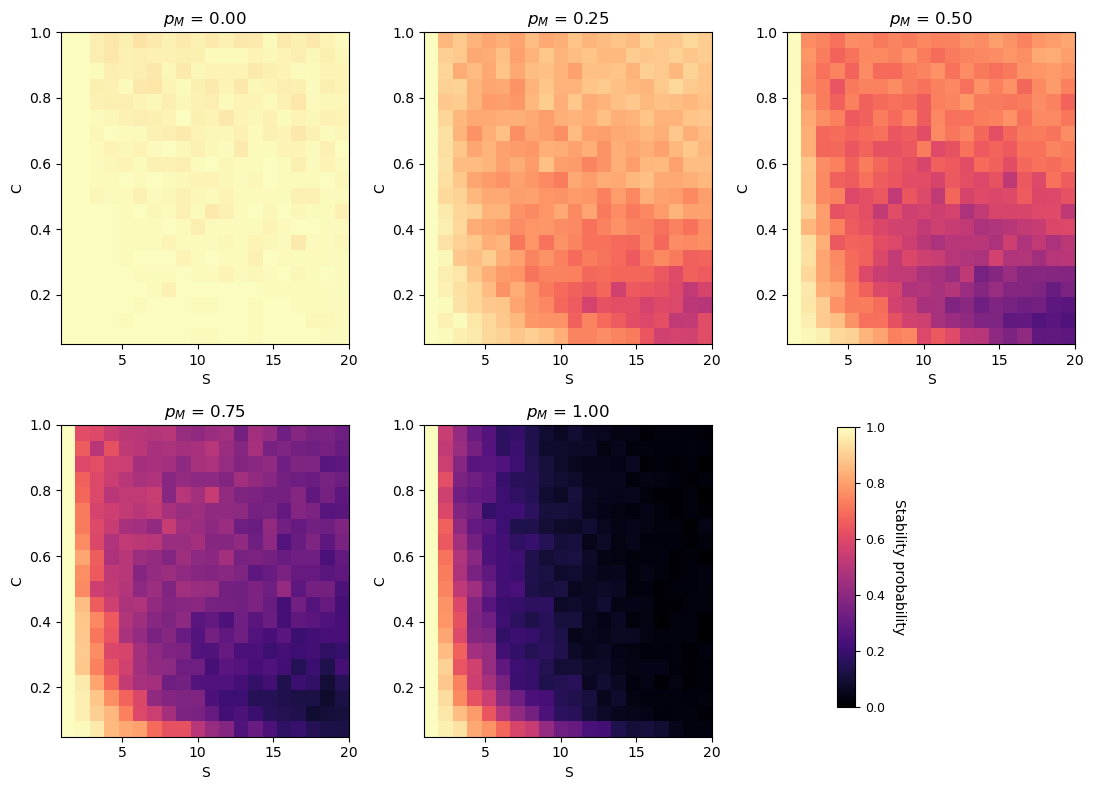

In [28]:
# parameter ranges
S_values = np.arange(1, 21)
C_values = np.linspace(0.05, 1.0, 20)
pM_values = [0.0, 0.25, 0.5, 0.75, 1.0]
n_realizations = 200

results = np.zeros((len(C_values), len(S_values)))

fig, axes = plt.subplots(2, 3, figsize=(12,8))
# Last axis (bottom-right) for colorbar
cbar_ax = axes.flat[-1]
# Remove the last subplot (we’ll use its space for colorbar)
fig.delaxes(cbar_ax)

for idx, pM in enumerate(pM_values):
    ax = axes.flat[idx]
    results = np.zeros((len(C_values), len(S_values)))
    for i, S in enumerate(S_values):
        for j, C in enumerate(C_values):
            stable_count = 0
            for _ in range(n_realizations):
                n_star = np.random.rand(S)
                a, _, _, _ = generate_matrix(S, C, pM=pM, fM=1, fA=1,
                                                            structure='cascade', CIE=True)
                r = construct_r_for_equilibrium(a, n_star)
                J = jacobian_at_equilibrium(a, n_star)
                stable = np.max(np.real(np.linalg.eigvals(J))) < 0
                #F = linearize(a, n_star)
                #vals = np.linalg.eigvals(F)
                if stable:
                    stable_count += 1
                results[j, i] = stable_count / n_realizations

    im = ax.imshow(results, origin='lower',
                   extent=[S_values[0], S_values[-1], C_values[0], C_values[-1]],
                   aspect='auto', cmap='magma', vmin=0, vmax=1)
    ax.set_title(f"$p_M$ = {pM:.2f}")
    ax.set_xlabel("S")
    ax.set_ylabel("C")
    

# --- Adjust layout and colorbar like Fig. 2B ---
plt.tight_layout(rect=[0, 0, 0.92, 1])  # leave space on right for colorbar

# Get position of deleted axis (bottom-right)
pos = axes[1, 2].get_position()
# Add colorbar axis roughly in the same slot but narrower
cbar_ax = fig.add_axes([pos.x0 + 0.03, pos.y0, 0.015, pos.height])

# Add vertical colorbar, matching Fig. 2B style
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel("Stability probability", rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=9)

plt.show()


## Effect of constant effort on different structures

Structure: mutualistic
  Realization 0
mutualistic, target C=0.1, realized C≈0.102
mutualistic, C=0.1
  mean positive effort: 0.12856523599992647 ± 0.025441839778386707
  mean negative effort: 0.47827695189768454 ± 0.30884123312924006
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
  Realization 0
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
  Realization 0
mutualistic, target C=0.5, realized C≈0.488
mutualistic, C=0.5
  mean positive effort: 0.12274674219303154 ± 0.011146599521740155
  mean negative effort: 0.4836768853683121 ± 0.2968788515188058
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
  Realization 0
  Realization 50
  Realization 100
  Rea

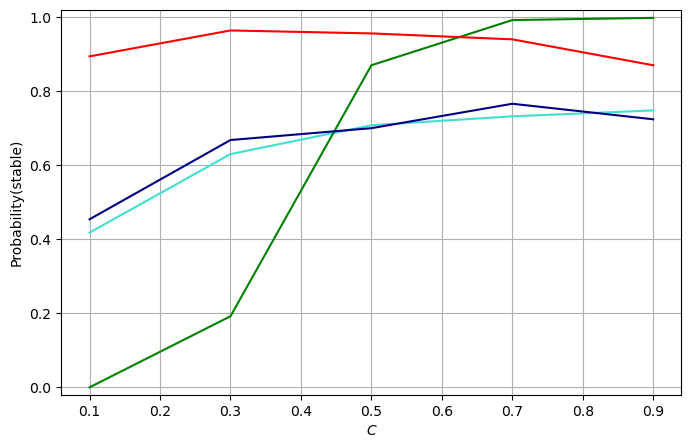

In [29]:
# Study CIE on mutualistic networks, predator-prey networks, 
# bipartite mutualistic networks, cascade predator-prey networks

structures = ['mutualistic', 'predator-prey', 'bipartite', 'cascade']

# S = 100, fA = 6, fM 0 .25 (for cascade fA = 30)
C_list = [.1,.3,.5,.7,.9]
S = 100
n_realizations = 500
results = {}

for structure in structures:

    fM = 0.25
    fA = 6.0
    if structure == 'cascade':
        fA = 3.0   
    print(f"Structure: {structure}")

    probs = np.zeros(len(C_list))
    for idx, C in enumerate(C_list):
        stable_count = 0

        for rep in range(n_realizations):

            if rep % 50 == 0: print(f"  Realization {rep}")
            # choose pM depending on interaction type
            if structure in ('mutualistic', 'bipartite'):
                pM = 1.0   # pure mutualism
            else:  # 'predator-prey' and 'cascade'
                pM = 0.0   # pure predator–prey
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            if rep == 0 and C in (0.1, 0.5, 0.9):  # debug
                # off-diagonal nonzero entries
                mask_off = ~np.eye(S, dtype=bool)
                realized_C = (np.abs(a)[mask_off] > 0).mean()
                print(f"{structure}, target C={C}, realized C≈{realized_C:.3f}")
                pos_effort = np.sum(np.clip(a, 0, np.inf), axis=1)
                neg_effort = -np.sum(np.clip(a, -np.inf, 0), axis=1)
                print(f"{structure}, C={C}")
                print("  mean positive effort:", pos_effort.mean(), "±", pos_effort.std())
                print("  mean negative effort:", neg_effort.mean(), "±", neg_effort.std())
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[structure] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['turquoise', 'green', 'navy', 'red']

for idx, struct in enumerate(structures):
    plt.plot(C_list, results[struct], color=color_list[idx])
    
plt.xlabel("$C$")
plt.ylabel("Probability(stable)")
#plt.title(f"Stability vs $p_M$ (cascade, S={S}, realizations={n_realizations}, fA=fM={fA})")
plt.ylim([-0.02,1.02])
plt.grid(True)
#plt.legend(title="Connectance")
plt.show()


Structure: mutualistic
  Realization 0
mean positive effort: 0.04671850108826575
std positive effort: 0.01865800339012972
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
mean positive effort: 0.04939043462199251
std positive effort: 0.021338215620053728
  Realization 0
mean positive effort: 0.14519543863329354
std positive effort: 0.031131639206573195
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
mean positive effort: 0.14993582395881686
std positive effort: 0.029837538338486482
  Realization 0
mean positive effort: 0.25045947238256194
std positive effort: 0.0381056757781729
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
  Realization 300
  Realization 350
  Realization 400
  Realization 450
mean positive effort: 0.24747

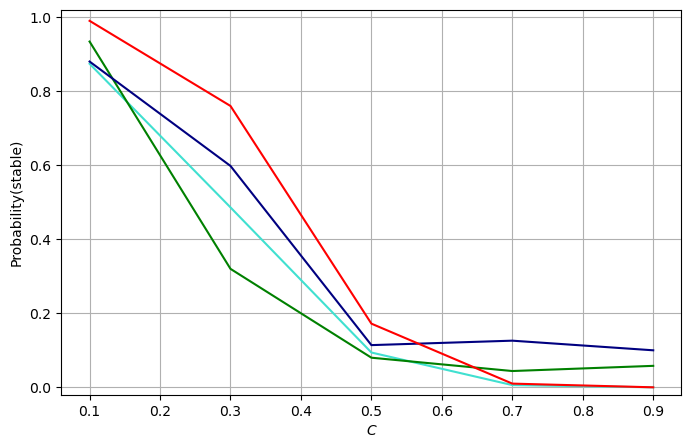

In [35]:
# Study CIE on mutualistic networks, predator-prey networks, 
# bipartite mutualistic networks, cascade predator-prey networks

structures = ['mutualistic', 'predator-prey', 'bipartite', 'cascade']

# S = 100, fA = 6, fM 0 .25 (for cascade fA = 30)
C_list = [.1,.3,.5,.7,.9]
S = 100
n_realizations = 500
results = {}

for structure in structures:

    fM = 0.02
    fA = 0.8 
    print(f"Structure: {structure}")

    probs = np.zeros(len(C_list))
    for idx, C in enumerate(C_list):
        stable_count = 0

        for rep in range(n_realizations):

            if rep % 50 == 0: print(f"  Realization {rep}")
            # choose pM depending on interaction type
            if structure in ('mutualistic', 'bipartite'):
                pM = 1.0   # pure mutualism
            else:  # 'predator-prey' and 'cascade'
                pM = 0.0   # pure predator–prey
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=False)
            if rep % (n_realizations-1) == 0:
                pos_effort = np.sum(np.clip(a, 0, np.inf), axis=1)

                print("mean positive effort:", pos_effort.mean())
                print("std positive effort:", pos_effort.std())
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[structure] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['turquoise', 'green', 'navy', 'red']

for idx, struct in enumerate(structures):
    plt.plot(C_list, results[struct], color=color_list[idx])
    
plt.xlabel("$C$")
plt.ylabel("Probability(stable)")
#plt.title(f"Stability vs $p_M$ (cascade, S={S}, realizations={n_realizations}, fA=fM={fA})")
plt.ylim([-0.02,1.02])
plt.grid(True)
#plt.legend(title="Connectance")
plt.show()


Structure: mutualistic
  Realization 0
mean positive effort: 0.0730410099719159
std positive effort: 0.016887235804722706
  Realization 50
mean positive effort: 0.07577316516650334
std positive effort: 0.006643156348287228
  Realization 0
mean positive effort: 0.07430034358672462
std positive effort: 0.008419855372193856
  Realization 50
mean positive effort: 0.07371102551595222
std positive effort: 0.006193536928057021
  Realization 0
mean positive effort: 0.076310249899678
std positive effort: 0.00628877478494894
  Realization 50
mean positive effort: 0.07506725447328198
std positive effort: 0.006221671649507791
  Realization 0
mean positive effort: 0.07513687045062231
std positive effort: 0.0058367872543487725
  Realization 50
mean positive effort: 0.07540540778585884
std positive effort: 0.005298661692208713
  Realization 0
mean positive effort: 0.0747906889431283
std positive effort: 0.005555560435488823
  Realization 50
mean positive effort: 0.07539292977664112
std positive effor

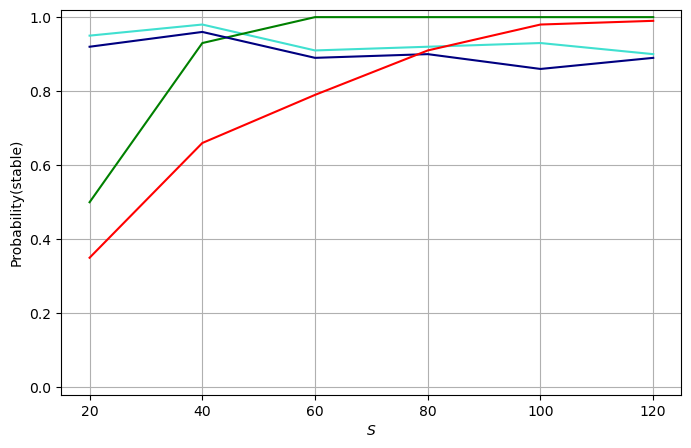

In [31]:
# Study CIE on mutualistic networks, predator-prey networks, 
# bipartite mutualistic networks, cascade predator-prey networks

structures = ['mutualistic', 'predator-prey', 'bipartite', 'cascade']

# S = 100, fA = 6, fM 0 .25 (for cascade fA = 30)
S_list = [20,40,60,80,100,120]
C = 1
n_realizations = 100
results = {}

for structure in structures:

    fM = 0.15
    fA = 6.0
    if structure == 'cascade':
        fA = 6.0   
    print(f"Structure: {structure}")

    probs = np.zeros(len(S_list))
    for idx, S in enumerate(S_list):
        stable_count = 0

        for rep in range(n_realizations):

            if rep % 50 == 0: print(f"  Realization {rep}")
            # choose pM depending on interaction type
            if structure in ('mutualistic', 'bipartite'):
                pM = 1.0   # pure mutualism
            else:  # 'predator-prey' and 'cascade'
                pM = 0.0   # pure predator–prey
            if structure == 'cascade':
                a, _, _, _ = generate_cascade_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            else: a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            if rep % (n_realizations-1) == 0:
                pos_effort = np.sum(np.clip(a, 0, np.inf), axis=1)

                print("mean positive effort:", pos_effort.mean())
                print("std positive effort:", pos_effort.std())
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[structure] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['turquoise', 'green', 'navy', 'red']

for idx, struct in enumerate(structures):
    plt.plot(S_list, results[struct], color=color_list[idx])
    
plt.xlabel("$S$")
plt.ylabel("Probability(stable)")
#plt.title(f"Stability vs $p_M$ (cascade, S={S}, realizations={n_realizations}, fA=fM={fA})")
plt.ylim([-0.02,1.02])
plt.grid(True)
#plt.legend(title="Connectance")
plt.show()


Structure: mutualistic
  Realization 0
mean positive effort: 0.09477489259585514
std positive effort: 0.01719351380371425
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
mean positive effort: 0.09454097580608323
std positive effort: 0.023810446142017782
  Realization 0
mean positive effort: 0.19629915652883115
std positive effort: 0.026018411040092695
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
mean positive effort: 0.19136405815119625
std positive effort: 0.02272287890522968
  Realization 0
mean positive effort: 0.3008266045381787
std positive effort: 0.0347316706628944
  Realization 50
  Realization 100
  Realization 150
  Realization 200
  Realization 250
mean positive effort: 0.300742745784551
std positive effort: 0.03214473779165883
  Realization 0
mean positive effort: 0.39370276076443195
std positive effort: 0.03965411336694168
  Realization 50
  Realization 100
  Realization 150
  Realization 

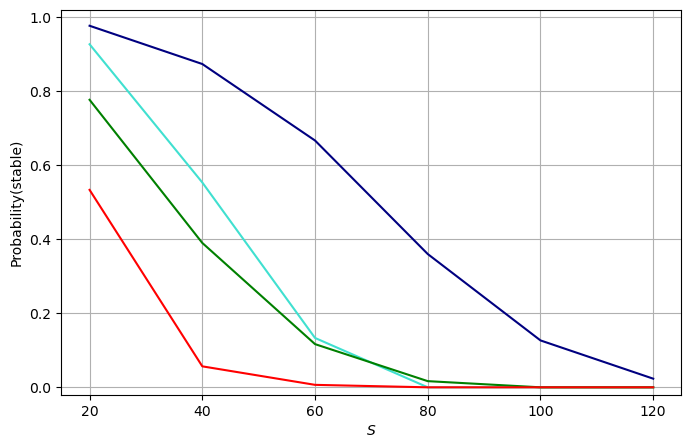

In [32]:
# Study CIE on mutualistic networks, predator-prey networks, 
# bipartite mutualistic networks, cascade predator-prey networks

structures = ['mutualistic', 'predator-prey', 'bipartite', 'cascade']

# S = 100, fA = 6, fM 0 .25 (for cascade fA = 30)
S_list = [20,40,60,80,100,120]
C = 1
n_realizations = 300
results = {}

for structure in structures:

    fM = 0.02
    fA = 1.0
    #if structure == 'cascade':
    #    fA = 3.0   
    print(f"Structure: {structure}")

    probs = np.zeros(len(S_list))
    for idx, S in enumerate(S_list):
        stable_count = 0

        for rep in range(n_realizations):

            if rep % 50 == 0: print(f"  Realization {rep}")
            # choose pM depending on interaction type
            if structure in ('mutualistic', 'bipartite'):
                pM = 1.0   # pure mutualism
            else:  # 'predator-prey' and 'cascade'
                pM = 0.0   # pure predator–prey
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=False)
            if rep % (n_realizations-1) == 0:
                pos_effort = np.sum(np.clip(a, 0, np.inf), axis=1)

                print("mean positive effort:", pos_effort.mean())
                print("std positive effort:", pos_effort.std())
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[structure] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['turquoise', 'green', 'navy', 'red']

for idx, struct in enumerate(structures):
    plt.plot(S_list, results[struct], color=color_list[idx])
    
plt.xlabel("$S$")
plt.ylabel("Probability(stable)")
#plt.title(f"Stability vs $p_M$ (cascade, S={S}, realizations={n_realizations}, fA=fM={fA})")
plt.ylim([-0.02,1.02])
plt.grid(True)
#plt.legend(title="Connectance")
plt.show()


## Fix pM = 0.5

Structure: mutualistic
  Realization 0
mutualistic, target C=0.1, realized C≈0.103
mutualistic, C=0.1
  mean positive effort: 0.07660915405979363 ± 0.016702390670641346
  mean negative effort: 0.5133222825458983 ± 0.2698884894354158
  Realization 50
  Realization 0
  Realization 50
  Realization 0
mutualistic, target C=0.5, realized C≈0.502
mutualistic, C=0.5
  mean positive effort: 0.07499199485385853 ± 0.0073363430671314536
  mean negative effort: 0.49219713410330074 ± 0.2889489658363856
  Realization 50
  Realization 0
  Realization 50
  Realization 0
mutualistic, target C=0.9, realized C≈0.905
mutualistic, C=0.9
  mean positive effort: 0.07534250457328782 ± 0.005197902265717084
  mean negative effort: 0.5380441161021567 ± 0.26777601055258043
  Realization 50
Structure: predator-prey
  Realization 0
predator-prey, target C=0.1, realized C≈0.103
predator-prey, C=0.1
  mean positive effort: 2.8851131165329424 ± 1.0697367392350579
  mean negative effort: 6.426303992944632 ± 3.232578830

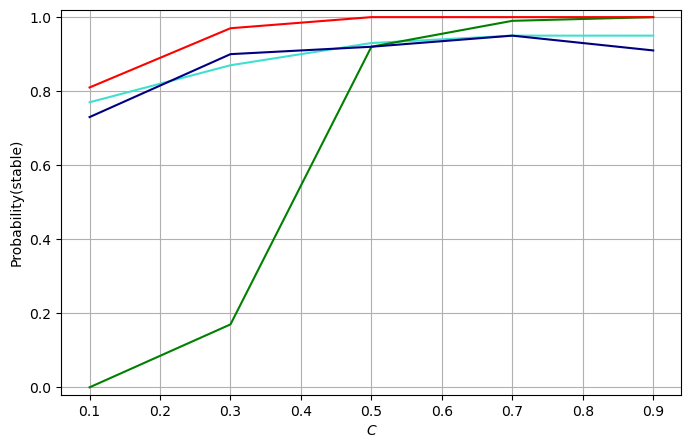

In [33]:
# Study CIE on mutualistic networks, predator-prey networks, 
# bipartite mutualistic networks, cascade predator-prey networks

structures = ['mutualistic', 'predator-prey', 'bipartite', 'cascade']

# S = 100, fA = 6, fM 0 .25 (for cascade fA = 30)
C_list = [.1,.3,.5,.7,.9]
S = 100
n_realizations = 100
results = {}

for structure in structures:

    fM = 0.15
    fA = 6.0
    if structure == 'cascade':
        fA = 10.0   
    print(f"Structure: {structure}")

    probs = np.zeros(len(C_list))
    for idx, C in enumerate(C_list):
        stable_count = 0

        for rep in range(n_realizations):

            if rep % 50 == 0: print(f"  Realization {rep}")
            # choose pM depending on interaction type
            if structure in ('mutualistic', 'bipartite'):
                pM = 1.0   # pure mutualism
            elif structure == 'cascade':
                pM = 0.5    
            else:  # 'predator-prey' and 'cascade'
                pM = 0.0   # pure predator–prey
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            if rep == 0 and C in (0.1, 0.5, 0.9):  # just a few checks
                # off-diagonal nonzero entries
                mask_off = ~np.eye(S, dtype=bool)
                realized_C = (np.abs(a)[mask_off] > 0).mean()
                print(f"{structure}, target C={C}, realized C≈{realized_C:.3f}")
                pos_effort = np.sum(np.clip(a, 0, np.inf), axis=1)
                neg_effort = -np.sum(np.clip(a, -np.inf, 0), axis=1)
                print(f"{structure}, C={C}")
                print("  mean positive effort:", pos_effort.mean(), "±", pos_effort.std())
                print("  mean negative effort:", neg_effort.mean(), "±", neg_effort.std())
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[structure] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['turquoise', 'green', 'navy', 'red']

for idx, struct in enumerate(structures):
    plt.plot(C_list, results[struct], color=color_list[idx])
    
plt.xlabel("$C$")
plt.ylabel("Probability(stable)")
#plt.title(f"Stability vs $p_M$ (cascade, S={S}, realizations={n_realizations}, fA=fM={fA})")
plt.ylim([-0.02,1.02])
plt.grid(True)
#plt.legend(title="Connectance")
plt.show()


## Stability of cascade as a function of fA

C=0.2, fA=0.01 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=1.588421052631579 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=3.1668421052631577 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=4.745263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=6.323684210526316 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=7.902105263157894 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=9.480526315789474 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=11.058947368421052 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=12.637368421052631 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=14.215789473684211 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=15.794210526315789 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=17.37263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=18.95105263157895 

  Real

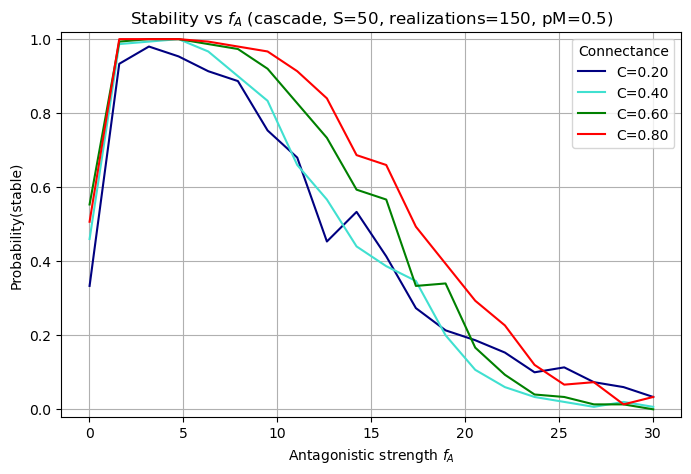

In [40]:
# Stability vs pM for cascade matrices
S = 50
C_list = [0.2, 0.4, 0.6, 0.8]
fA_grid = np.linspace(0.01, 30.0, 20)
#fA = 0.5
fM = 0.5
structure = 'cascade'
n_realizations = 150
pM = 0.5
results = {}
for C in C_list:
    probs = np.zeros(len(fA_grid))
    for idx, fA in enumerate(fA_grid):
        print(f"C={C}, fA={fA} \n")
        stable_count = 0
        for rep in range(n_realizations):
            if rep % 50 == 0: print(f"  Realization {rep}")
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[C] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['navy', 'turquoise', 'green', 'red']
count = 0
for C in C_list:
    plt.plot(fA_grid, results[C], label=f"C={C:.2f}", color=color_list[count])
    count += 1
plt.xlabel("Antagonistic strength $f_A$")
plt.ylabel("Probability(stable)")
plt.title(f"Stability vs $f_A$ (cascade, S={S}, realizations={n_realizations}, pM={pM})")
plt.ylim([-0.02,1.02])
plt.grid(True)
plt.legend(title="Connectance")
plt.show()


C=0.2, fA=0.01 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=1.588421052631579 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=3.1668421052631577 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=4.745263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=6.323684210526316 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=7.902105263157894 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=9.480526315789474 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=11.058947368421052 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=12.637368421052631 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=14.215789473684211 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=15.794210526315789 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=17.37263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=18.95105263157895 

  Real

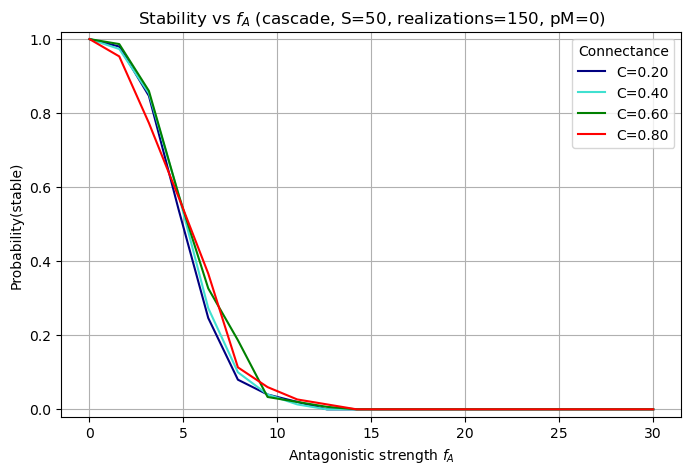

In [41]:
# Stability vs pM for cascade matrices
S = 50
C_list = [0.2, 0.4, 0.6, 0.8]
fA_grid = np.linspace(0.01, 30.0, 20)
#fA = 0.5
fM = 0.5
structure = 'cascade'
n_realizations = 150
pM = 0
results = {}
for C in C_list:
    probs = np.zeros(len(fA_grid))
    for idx, fA in enumerate(fA_grid):
        print(f"C={C}, fA={fA} \n")
        stable_count = 0
        for rep in range(n_realizations):
            if rep % 50 == 0: print(f"  Realization {rep}")
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[C] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['navy', 'turquoise', 'green', 'red']
count = 0
for C in C_list:
    plt.plot(fA_grid, results[C], label=f"C={C:.2f}", color=color_list[count])
    count += 1
plt.xlabel("Antagonistic strength $f_A$")
plt.ylabel("Probability(stable)")
plt.title(f"Stability vs $f_A$ (cascade, S={S}, realizations={n_realizations}, pM={pM})")
plt.ylim([-0.02,1.02])
plt.grid(True)
plt.legend(title="Connectance")
plt.show()


C=0.2, fA=0.01 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=1.588421052631579 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=3.1668421052631577 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=4.745263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=6.323684210526316 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=7.902105263157894 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=9.480526315789474 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=11.058947368421052 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=12.637368421052631 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=14.215789473684211 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=15.794210526315789 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=17.37263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=18.95105263157895 

  Real

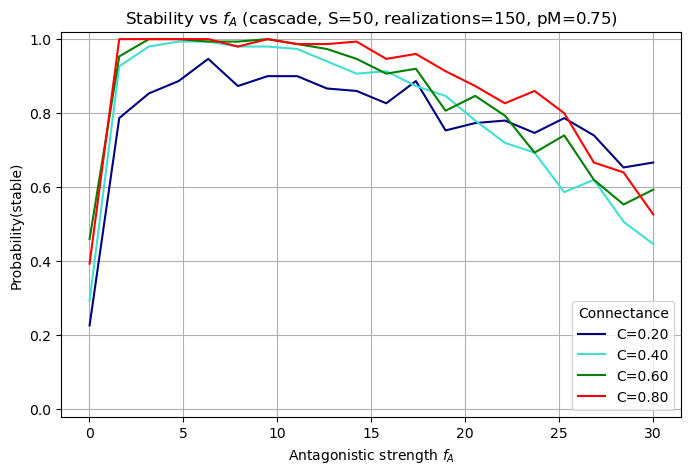

In [42]:
# Stability vs pM for cascade matrices
S = 50
C_list = [0.2, 0.4, 0.6, 0.8]
fA_grid = np.linspace(0.01, 30.0, 20)
#fA = 0.5
fM = 0.5
structure = 'cascade'
n_realizations = 150
pM = 0.75
results = {}
for C in C_list:
    probs = np.zeros(len(fA_grid))
    for idx, fA in enumerate(fA_grid):
        print(f"C={C}, fA={fA} \n")
        stable_count = 0
        for rep in range(n_realizations):
            if rep % 50 == 0: print(f"  Realization {rep}")
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[C] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['navy', 'turquoise', 'green', 'red']
count = 0
for C in C_list:
    plt.plot(fA_grid, results[C], label=f"C={C:.2f}", color=color_list[count])
    count += 1
plt.xlabel("Antagonistic strength $f_A$")
plt.ylabel("Probability(stable)")
plt.title(f"Stability vs $f_A$ (cascade, S={S}, realizations={n_realizations}, pM={pM})")
plt.ylim([-0.02,1.02])
plt.grid(True)
plt.legend(title="Connectance")
plt.show()


C=0.2, fA=0.01 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=1.588421052631579 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=3.1668421052631577 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=4.745263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=6.323684210526316 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=7.902105263157894 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=9.480526315789474 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=11.058947368421052 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=12.637368421052631 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=14.215789473684211 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=15.794210526315789 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=17.37263157894737 

  Realization 0
  Realization 50
  Realization 100
C=0.2, fA=18.95105263157895 

  Real

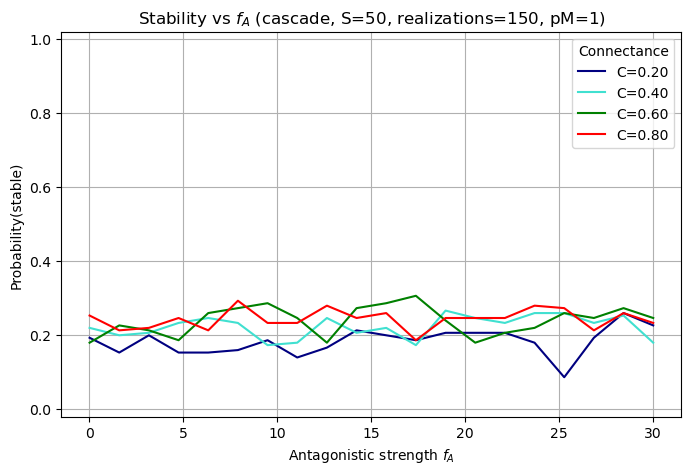

In [43]:
# Stability vs pM for cascade matrices
S = 50
C_list = [0.2, 0.4, 0.6, 0.8]
fA_grid = np.linspace(0.01, 30.0, 20)
#fA = 0.5
fM = 0.5
structure = 'cascade'
n_realizations = 150
pM = 1
results = {}
for C in C_list:
    probs = np.zeros(len(fA_grid))
    for idx, fA in enumerate(fA_grid):
        print(f"C={C}, fA={fA} \n")
        stable_count = 0
        for rep in range(n_realizations):
            if rep % 50 == 0: print(f"  Realization {rep}")
            
            a, _, _, _ = generate_matrix(S=S, C=C, pM=pM, fM=fM, fA=fA, structure=structure, CIE=True)
            n_star = np.random.random(S)
            r = construct_r_for_equilibrium(a, n_star)
            J = jacobian_at_equilibrium(a, n_star)
            stable = np.max(np.real(np.linalg.eigvals(J))) < 0
            #F = linearize(a, n_star)
            #vals = np.linalg.eigvals(F)
            if stable:
                stable_count += 1
        probs[idx] = stable_count / n_realizations
    results[C] = probs

# Plot
plt.figure(figsize=(8,5))
color_list = ['navy', 'turquoise', 'green', 'red']
count = 0
for C in C_list:
    plt.plot(fA_grid, results[C], label=f"C={C:.2f}", color=color_list[count])
    count += 1
plt.xlabel("Antagonistic strength $f_A$")
plt.ylabel("Probability(stable)")
plt.title(f"Stability vs $f_A$ (cascade, S={S}, realizations={n_realizations}, pM={pM})")
plt.ylim([-0.02,1.02])
plt.grid(True)
plt.legend(title="Connectance")
plt.show()
